### The Requirements:
Step 1: Choose an ETF with a minimum of 100 assets, identify those assets

Step 2: Retrieve historical data for your chosen ETF

Step 3: Calculate the price momentum factors for each asset in your ETF

Step 4: Using the price momentum factors, calculate the monthly z-factor score for each asset

Step 5: Identify long and short baskets (10 to 15 assets in each) using calculated z-factors

Step 6: Create a backtest to validate performance of your algorithm based on monthly restructuring over the previous 5 years.

Step 7: Chart:

1. Monthly portfolio return bar chart (pos/neg coloring) vs ETF

2. Monthly return for/ long picks vs short picks vs ETF

3. Cumulative portfolio return vs ETF

In [38]:
# Import Libraries
import pandas as pd
import yfinance as yf

import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Factors:
    
    def __init__(self) -> None:
        pass
    
    def get_data(tickers_list):
        # Step 2: Retrieve historical data for your chosen ETF
        # Adj Close
        df = yf.download(tickers_list, period = '10y')['Adj Close']
        return df

In [4]:
# Step 1: Choose an ETF with a minimum of 100 assets, identify those assets
# etf = ["SPY"]

# Get the list of S&P 500 constituents
# SPY_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()
SPY_tickers = pd.read_excel("https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx", header=4).Ticker.dropna().to_list()

print(f'{len(SPY_tickers)} tickers')


504 tickers


In [5]:
# Step 2: Retrieve historical data for your chosen ETF
df = yf.download(SPY_tickers, period = '10y')['Adj Close']


[*********************100%%**********************]  504 of 504 completed


17 Failed downloads:
['MRK', 'TMO', 'AMT', 'GRMN', 'DIS', 'NKE', 'EMN', 'RCL', 'ICE', 'FIS', 'DTE', 'TROW', 'KDP', 'VTR']: TypeError("unsupported operand type(s) for |: 'dict' and 'dict'")
['-', 'BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')


In [6]:
# Drop na
sp500 = df.dropna(how= 'all', axis= 1)
# sp500.head()
returns = sp500.pct_change()

In [7]:
# Get a clean list of ticker list with data
tickers = list(sp500.columns)

In [55]:
# Step 3: Calculate the price momentum factors for each asset in your ETF


In [10]:

# Calculate the 52-week rolling mean
rolling_mean = sp500['A'].rolling(window=252).mean()

# Drop NaN values introduced by the rolling mean calculation
rolling_mean = rolling_mean.dropna()

# Prepare data for linear regression
X = np.arange(len(rolling_mean)).reshape(-1, 1)
y = rolling_mean.values.reshape(-1, 1)

# Use NumPy for linear regression
slope = np.polyfit(X.flatten(), y.flatten(), 1)[0]

# Print the calculated slope
print("52-Week Slope:", slope)


52-Week Slope: 0.05553088193744345


In [11]:
# Calculate the 52-week rolling mean with a 20 day lag 
# Drop NaN values introduced by the rolling mean calculation
lagged_rolling_mean = rolling_mean.shift(20).dropna()

# Prepare data for linear regression
X = np.arange(len(lagged_rolling_mean)).reshape(-1, 1)
y = lagged_rolling_mean.values.reshape(-1, 1)

# Use NumPy for linear regression
slope = np.polyfit(X.flatten(), y.flatten(), 1)[0]

# Print the calculated slope
print("52-Week Slope:", slope)

52-Week Slope: 0.055836418460213005


In [12]:

# 20 day lag time period 
starting_period = -20 -252
end_period = -20
lagged_closed_price = sp500[starting_period : end_period]

# calculating 52 Week trend 
polyfit_regression = np.polyfit((range(0,252)), lagged_closed_price, 1) 
# The first parameter of our regression is x, 0-252 days. Second is the y, Closing price for slice of data with 20 - day lag
slope_info = pd.DataFrame(polyfit_regression) # Convert so that we can use the results
slope_info.columns = sp500.columns # Setting column names to match ticker
_52_week_trend= slope_info.iloc[0] # Only need first row 
_52_week_trend

A      -0.202684
AAL    -0.005747
AAPL    0.208244
ABBV   -0.037978
ABNB    0.153597
          ...   
YUM    -0.000618
ZBH    -0.035719
ZBRA   -0.228396
ZION   -0.072524
ZTS     0.111694
Name: 0, Length: 487, dtype: float64

In [13]:
def trendline(ticker):
    df = pd.DataFrame(index=tickers)
    
    # for 20 day
    for i in range(1,21):
        df[i] = np.polyfit(range(len(sp500[-i - 252 : -i])), sp500[-i - 252 : -i], 1)[0]
    # averages out the day
    return df.mean(axis=1)
    
slope = trendline(ticker=tickers)
slope

A      -0.193796
AAL    -0.007913
AAPL    0.212695
ABBV   -0.040952
ABNB    0.144656
          ...   
YUM    -0.007900
ZBH    -0.055338
ZBRA   -0.277950
ZION   -0.060711
ZTS     0.099903
Length: 487, dtype: float64

### factor two - Percent Aboce 260-Day Low

- calculates the percentage difference between the current adjusted close price and the minimum adjusted close price over the past 260 days

- highlights how much the price has risen vs its lowest point over the past year

- higher percentage means the price is farther above the annual low

In [30]:
# factor two - Percent Aboce 260-Day Low
## calculates the percentage difference between the current adjusted close price and the minimum adjusted close price over the past 260 days
## highlights how much the price has risen vs its lowest point over the past year
## 
_260_day_low = sp500.rolling(window=260).min()
# Percent_Above_260Day_Low = (sp500 - _260_day_low) / (data['High'].rolling(window=260 - lag).max() - data['Low'].rolling(window=260 - lag).min()) * 100
Percent_Above_260Day_Low = (sp500 - _260_day_low) / _260_day_low * 100
Percent_Above_260Day_Low = Percent_Above_260Day_Low.mean()
Percent_Above_260Day_Low

A       31.467455
AAL     39.398867
AAPL    48.185816
ABBV    34.731540
ABNB    33.499610
          ...    
YUM     31.013485
ZBH     27.242573
ZBRA    55.835282
ZION    44.767270
ZTS     38.970628
Length: 487, dtype: float64

In [48]:
# lets see the ones above 50%
Percent_Above_260Day_Low[Percent_Above_260Day_Low > 50].sort_values()

MSCI     50.162328
CDNS     50.322312
BA       50.323928
TPR      50.517914
AMZN     50.661014
           ...    
NVDA    119.123363
TSLA    140.397279
CZR     158.963148
ENPH    197.135666
MRNA    213.949547
Length: 80, dtype: float64

In [49]:
# lets see the ones below 50%
Percent_Above_260Day_Low[Percent_Above_260Day_Low < 50].sort_values()

VZ      14.599790
CL      14.957412
K       16.104989
D       16.542877
KMB     18.143552
          ...    
STX     49.587548
COP     49.755032
NXPI    49.755707
CCL     49.885909
CF      49.994788
Length: 404, dtype: float64

### Factor 3: 4/52 Week Price Oscillator
- calculates the percentage difference between the 4-week moving average and the 52-week moving average of the adjusted close prices

- we can understand this as:
    - helps identify short term trends compared to longer trends
    - a positive = short-term trend has a stronger strength relative to the long-term trend

In [62]:
# Factor 3: 4/52 Week Price Oscillator

short_term = sp500.rolling(window=4*5).mean()
long_term = sp500.rolling(window=52*5).mean()

oscillator = ((short_term - long_term) / long_term * 100)[-20:]

oscillator.mean()


A      -12.136049
AAL    -17.140625
AAPL    10.756505
ABBV    -3.936718
ABNB     3.578007
          ...    
YUM     -2.704382
ZBH    -12.167353
ZBRA   -19.925872
ZION    -5.805774
ZTS      1.445489
Length: 487, dtype: float64

In [61]:
# Factor 3: 4/52 Week Price Oscillator
## multiply by 5 assuming 5 trading days
short_term = sp500.rolling(window=4*5).mean()
long_term = sp500.rolling(window=52*5).mean()

#oscillator = (short_term - long_term) / long_term * 100
oscillator = (short_term - long_term) / long_term * 100
# oscillator = oscillator.dropna(how='all').mean() 
oscillator.mean()
# data['Price_Oscillator'] = (data['Close'].rolling(window=4).mean() / data['Close'].rolling(window=52).mean() - 1) * 100

A        6.630750
AAL     -4.141025
AAPL    11.907792
ABBV     7.413390
ABNB    -5.808878
          ...    
YUM      5.852921
ZBH      1.642480
ZBRA     8.001631
ZION     2.606911
ZTS      9.314287
Length: 487, dtype: float64

In [68]:
# using only the last 20 enties
# oscillator = ((short_term - long_term) / long_term.std())[-20:]
oscillator = ((short_term - long_term) / long_term * 100)[-20:]

oscillator.mean()


A      -12.136049
AAL    -17.140625
AAPL    10.756505
ABBV    -3.936718
ABNB     3.578007
          ...    
YUM     -2.704382
ZBH    -12.167353
ZBRA   -19.925872
ZION    -5.805774
ZTS      1.445489
Length: 487, dtype: float64

### Factor 4: 39-week return

In [ ]:
# Factor 4: 39-week return

# _39_week_return = sp500[::39*5].pct_change(39*5) * 100

#_39_week_return = lagged_closed_price[::39*5].pct_change().dropna(how='all').mean() 


In [15]:
# Step 3: Calculate the price momentum factors for each asset in your ETF

def calculate_momentum_factors(tickers, lag=20):
    
    # data['52_week_trend_slope'] = slope
    
    
    # Factor 2: Percent above 260-day low
    


    
    # Factor 3: 4/52 Week Price Oscillator (20-day lag)


    # Factor 4: 39-week return (20-day lag)
    data['39Week_Return'] = data['Close'].pct_change(39 - lag) * 100

    # Factor 5: 51-week Volume Price Trend (20-day lag)
    data['Volume_Price_Trend'] = (data['Close'].pct_change() * data['Volume']).rolling(window=51 - lag).sum()

    return data[['Slope_52Week', 'Percent_Above_260Day_Low', 'Price_Oscillator', '39Week_Return', 'Volume_Price_Trend']]

# Apply the function to ETF data and asset data
#etf_momentum_factors = calculate_momentum_factors(data)
all_asset = {}

for asset in tickers:
    assets_momentum_factors = sp500[asset].apply(calculate_momentum_factors)

# Display the calculated price momentum factors
# print("ETF Momentum Factors:")
# print(etf_momentum_factors.head())
print("\nAsset Momentum Factors:")
print(assets_momentum_factors.head())

# # Displaying the signals for each asset
# for asset, signals in assets_momentum_factors.items():
#     print(f"Signals for {asset}:\n{signals}\n")



NameError: name 'data' is not defined

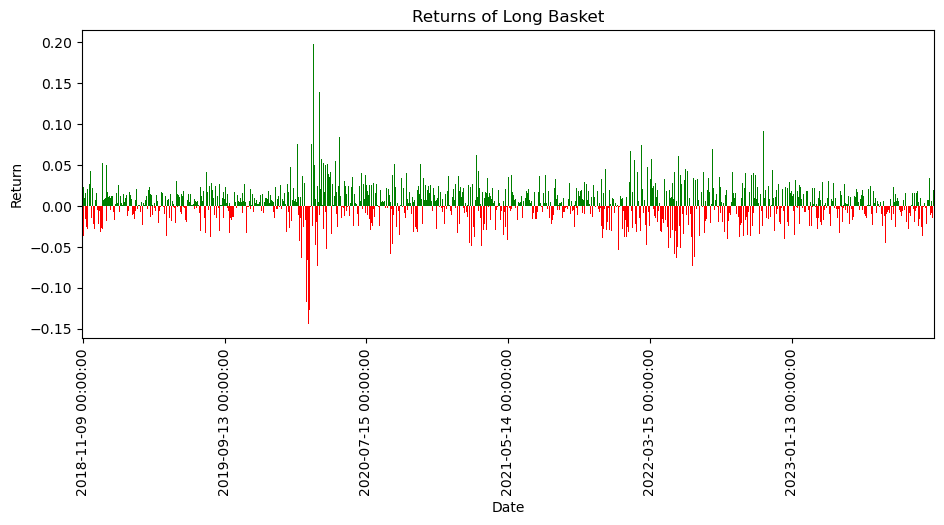

In [ ]:
graphing = pd.DataFrame(long_returns.mean(axis=1))
graphing.columns = ['Returns']

colors = ['r' if m < 0 else 'g' for m in graphing.Returns]
graphing.plot.bar(figsize=(11,4), y='Returns',color=colors, legend=False,width=1.3)
plt.locator_params(axis='x', nbins=6)

# # Format date ticks on the x-axis
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # Set the locator to show a reasonable number of ticks
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# # Rotate x-axis labels for better visibility (optional)
# plt.gcf().autofmt_xdate()


plt.ylabel('Return')
plt.title('Returns of Long Basket')
plt.show()

